<a href="https://colab.research.google.com/github/Jack-Chuang/UW-CSE-455/blob/main/final%20project/cutout_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pdb
import argparse
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision.utils import make_grid
from torchvision import datasets, transforms

In [ ]:
# from misc and resnet
import torch.nn.functional as F
import csv

misc file

In [ ]:
class CSVLogger():
    def __init__(self, args, fieldnames, filename='log.csv'):

        self.filename = filename
        self.csv_file = open(filename, 'w')

        # Write model configuration at top of csv
        writer = csv.writer(self.csv_file)
        for arg in vars(args):
            writer.writerow([arg, getattr(args, arg)])
        writer.writerow([''])

        self.writer = csv.DictWriter(self.csv_file, fieldnames=fieldnames)
        self.writer.writeheader()

        self.csv_file.flush()

    def writerow(self, row):
        self.writer.writerow(row)
        self.csv_file.flush()

    def close(self):
        self.csv_file.close()

cutout file

In [ ]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        print('One image')
        imshow(img)

        return img


Resnet file

In [ ]:
from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

def test_resnet():
    net = ResNet50()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

# test_resnet()

In [ ]:
parser = argparse.ArgumentParser(description='CNN')
parser.add_argument('--dataset', '-d', default='cifar10',
                   )
#parser.add_argument('--dataset', '-d', default='cifar10', Cutout = True)

_StoreAction(option_strings=['--dataset', '-d'], dest='dataset', nargs=None, const=None, default='cifar10', type=None, choices=None, help=None, metavar=None)

In [ ]:
args = parser.parse_args("")

In [ ]:
args.dataset

'cifar10'

Mod

In [ ]:
model_options = ['resnet18', 'wideresnet']
dataset_options = ['cifar10', 'cifar100', 'svhn']

parser = argparse.ArgumentParser(description='CNN')
parser.add_argument('--dataset', '-d', default='cifar10',
                    choices=dataset_options)
parser.add_argument('--model', '-a', default='resnet18',
                    choices=model_options)
parser.add_argument('--batch_size', type=int, default=128,
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=1,
                    help='number of epochs to train (default: 20)')
parser.add_argument('--learning_rate', type=float, default=0.1,
                    help='learning rate')
parser.add_argument('--data_augmentation', action='store_true', default=False,
                    help='augment data by flipping and cropping')
parser.add_argument('--cutout', action='store_true', default=True, #changed
                    help='apply cutout')
parser.add_argument('--n_holes', type=int, default=3,
                    help='number of holes to cut out from image')
parser.add_argument('--length', type=int, default=16,
                    help='length of the holes')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=0,
                    help='random seed (default: 1)')

args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

test_id = args.dataset + '_' + args.model

print(args)

Namespace(batch_size=128, cuda=False, cutout=True, data_augmentation=False, dataset='cifar10', epochs=1, learning_rate=0.1, length=16, model='resnet18', n_holes=3, no_cuda=False, seed=0)


Mod

In [ ]:


# Image Preprocessing
if args.dataset == 'svhn':
    normalize = transforms.Normalize(mean=[x / 255.0 for x in[109.9, 109.7, 113.8]],
                                     std=[x / 255.0 for x in [50.1, 50.6, 50.8]])
else:
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])
if args.data_augmentation:
    train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)
if args.cutout:
    train_transform.transforms.append(Cutout(n_holes=args.n_holes, length=args.length))


test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

if args.dataset == 'cifar10':
    num_classes = 10
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)
elif args.dataset == 'cifar100':
    num_classes = 100
    train_dataset = datasets.CIFAR100(root='data/',
                                      train=True,
                                      transform=train_transform,
                                      download=True)

    test_dataset = datasets.CIFAR100(root='data/',
                                     train=False,
                                     transform=test_transform,
                                     download=True)
elif args.dataset == 'svhn':
    num_classes = 10
    train_dataset = datasets.SVHN(root='data/',
                                  split='train',
                                  transform=train_transform,
                                  download=True)

    extra_dataset = datasets.SVHN(root='data/',
                                  split='extra',
                                  transform=train_transform,
                                  download=True)

    # Combine both training splits (https://arxiv.org/pdf/1605.07146.pdf)
    data = np.concatenate([train_dataset.data, extra_dataset.data], axis=0)
    labels = np.concatenate([train_dataset.labels, extra_dataset.labels], axis=0)
    train_dataset.data = data
    train_dataset.labels = labels

    test_dataset = datasets.SVHN(root='data/',
                                 split='test',
                                 transform=test_transform,
                                 download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)
#train_loader, _ = torch.utils.data.random_split(train_loader, [10, 381])

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=args.batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)
#test_loader, _ = torch.utils.data.random_split(test_loader, [5, 74])

if args.model == 'resnet18':
    cnn = ResNet18(num_classes=num_classes)
elif args.model == 'wideresnet':
    if args.dataset == 'svhn':
        cnn = WideResNet(depth=16, num_classes=num_classes, widen_factor=8,
                         dropRate=0.4)
    else:
        cnn = WideResNet(depth=28, num_classes=num_classes, widen_factor=10,
                         dropRate=0.3)


criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=args.learning_rate,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)

if args.dataset == 'svhn':
    scheduler = MultiStepLR(cnn_optimizer, milestones=[80, 120], gamma=0.1)
else:
    scheduler = MultiStepLR(cnn_optimizer, milestones=[60, 120, 160], gamma=0.2)

filename = 'logs/' + test_id + '.csv'
#csv_logger = CSVLogger(args=args, fieldnames=['epoch', 'train_acc', 'test_acc'], filename=filename)


def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.
    total = 0.
    for images, labels in loader:

        with torch.no_grad():
            pred = cnn(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = correct / total
    cnn.train()
    return val_acc




Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
import torchvision
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


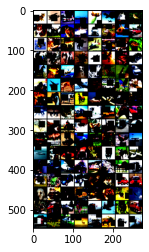

In [ ]:
imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


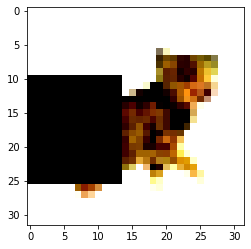

In [ ]:
imshow(images[0])

  0%|          | 0/391 [00:00<?, ?it/s]

One image
One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


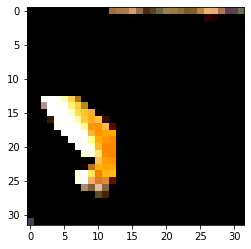

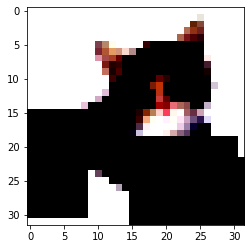

One image
One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


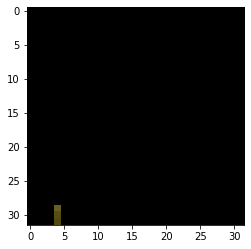

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


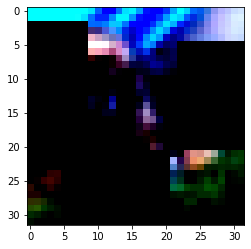

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


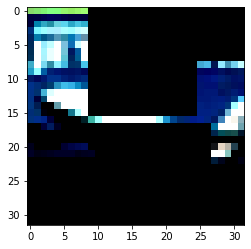

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


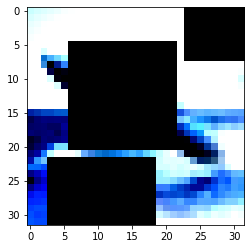

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


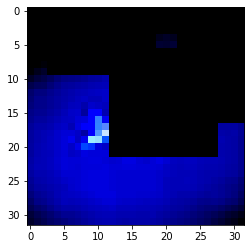

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


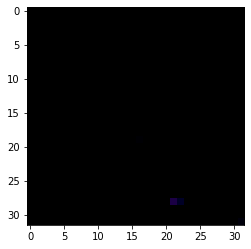

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


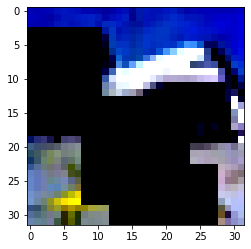

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


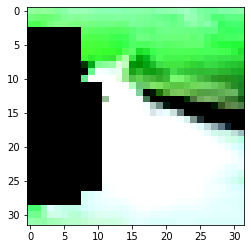

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


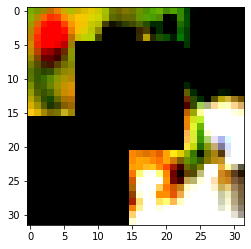

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


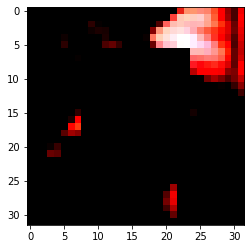

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


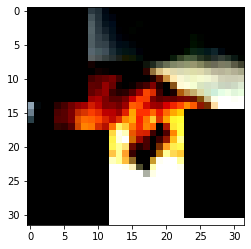

One image


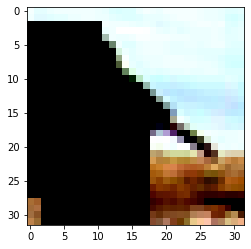

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


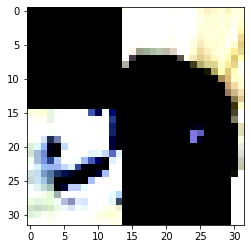

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


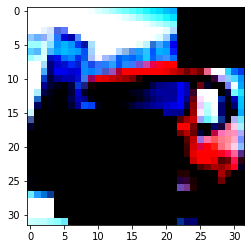

One image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/391 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(args.epochs):

    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))




        cnn.zero_grad()
        pred = cnn(images)

        xentropy_loss = criterion(pred, labels)
        xentropy_loss.backward()
        cnn_optimizer.step()

        xentropy_loss_avg += xentropy_loss.item()

        # Calculate running average of accuracy
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels.data).sum().item()
        accuracy = correct / total

        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)

    test_acc = test(test_loader)
    tqdm.write('test_acc: %.3f' % (test_acc))

    scheduler.step(epoch)  # Use this line for PyTorch <1.4
    # scheduler.step()     # Use this line for PyTorch >=1.4

    row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    #csv_logger.writerow(row)
    print(row)

torch.save(cnn.state_dict(), 'checkpoints/' + test_id + '.pt')
#csv_logger.close()
